# Skill assessment - analysis
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 28-03-2023<br>


**Introduction**:<br>
In this notebook I will analyse the EFAS skill in predicting flood events in general, i.e., looking whether events where predicted at some point in time, regardless of neither the offset nor the duration of the event.

**Questions**:<br>

* [ ] Take into account the model spread?
* [ ] Aggregate results by river/administrative area? EFAS aims at alerting administrations about incoming events in there administrative area, shouldn't that aggregation be included in the results?
* [ ] Remove extremely bad performing stations.

**Pending tasks**:<br>

* [x] Weighting the model average by the Brier score?
* [x] Sort stations by catchment area (or other order)?
* [x] Persistence
* [ ] Analyse only the periods/stations close to an observed event and compute f1 for this extraction. Later on, on the complementary subset of data another metric must be computed to avoid false positives, p.e., false alarm ratio.



**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [1]:
import os
import sys
import operator
import glob
import numpy as np
import pandas as pd
import xarray as xr
# import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pickle

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from computations import *
from plots import *
os.chdir(path_root)

## 1 Configuration

In [2]:
# path that contains the NetCDF with hit, misses and false alarms
path_in = '../data/hits/'

# path where results will be saved
path_out = f'../results/skill/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

## 2 Data

### 2.1 Stations

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [3]:
# load table of fixed reporing points
area_threshold = 500
stations = pd.read_parquet(f'../results/reporting_points/reporting_points_over_{area_threshold}km2.parquet')

In [4]:
# select stations with events
mask_stn = (stations.n_events_obs > 0)
print('no. stations with events:\t{0}'.format(mask_stn.sum()))

no. stations with events:	879


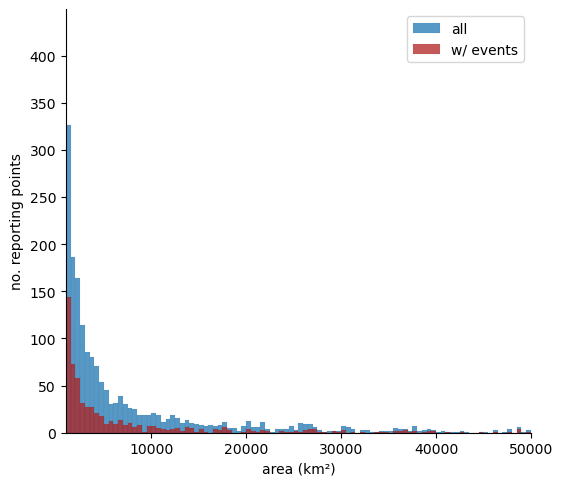

In [5]:
bins = np.arange(area_threshold, 500001, 500)

fig, ax = plt.subplots(figsize=(6, 5.5))
sns.histplot(stations.area, ax=ax, bins=bins, label='all')
sns.histplot(stations[mask_stn].area, ax=ax, color='firebrick', bins=bins, label='w/ events')
ax.set(xlabel='area (km²)', ylabel='no. reporting points', xlim=(1000, 50000));
ax.spines[['right', 'top']].set_visible(False)
ax.legend();
plt.savefig(f'{path_out}area_distribution_{area_threshold}km2.jpg', dpi=300, bbox_inches='tight')

In [23]:
stations.shape

(2370, 20)

In [24]:
stations.n_events_obs.sum()

1293

In [19]:
# remove station with erroneous behaviour
stations.drop(2996, axis=0, inplace=True)

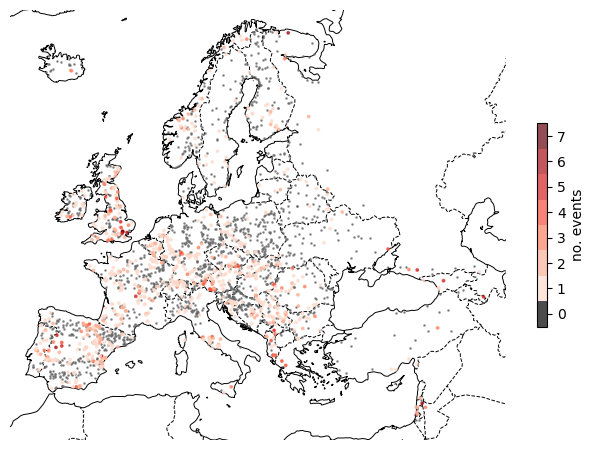

In [22]:
# colormap used for the maps
max_events = stations.n_events_obs.max()
cmap, norm = create_cmap('Reds', np.arange(max_events + 2), 'no. events', [0, (0, 0, 0, 1)])
plot_map_stations(stations.X, stations.Y, stations.n_events_obs, mask=~mask_stn,
                  cmap=cmap, norm=norm, size=3, figsize=(8, 8),alpha=.7)
ticks = np.arange(max_events + 1)
cbar = plt.colorbar(plot_map_stations.colorbar, shrink=.33, label='no. events', ticks= ticks+ .5)
cbar.ax.set_yticklabels(ticks)
plt.savefig(f'{path_out}/map_observed_events.png', dpi=300, bbox_inches='tight');

In [18]:
stations.loc[stations.n_events_obs == 6]

name          X          Y     area  \
id                                                                        
1569  River Lee At Feildes Weir (Gauged)  3632500.0  3232500.0   1125.0   
2275                      AGAN NAHARAYIM  6707500.0  1467500.0  53050.0   
2390                         RUSHES LOCK  3677500.0  3222500.0   1025.0   
2596                 SEREBRYANSKIY GES 1  5332500.0  5272500.0   8825.0   
2999                     Gabriel y Galan  2947500.0  2042500.0   2425.0   
4003                          Ura_Leklit  5177500.0  1962500.0   1325.0   
4324                              Arenos  3417500.0  1952500.0   1450.0   

           subcatchment    river catchment country  strahler  pfafstetter  \
id                                                                          
1569                Lee      Lee    Thames      UK       2.0           22   
2275  Jordan / Dead Sea   Jordan    Jordan      JO       1.0            1   
2390            Chelmer  Chelmer   Chelmer      UK       1.0            1   
2596            Voronja  Voronja   Voronja      RU       1.0            1   
2999              Tagus   Alagon     Tagus      ES       2.0          611   
4003              Vjosa   Drinos     Vjosa      AL       2.0            2   
4324            Mijares  Mijares   Mijares      ES       1.0            3   

      rl1.5     rl2     rl5    rl10    rl20    rl50   rl100   rl200   rl500  \
id                                                                            
1569   31.2    36.2    48.3    56.4    64.1    74.1    81.6    89.1    98.9   
2275  738.7  1198.5  2330.1  3079.3  3797.9  4728.1  5425.2  6119.8  7036.1   
2390   21.0    25.5    36.4    43.6    50.5    59.5    66.2    72.9    81.8   
2596  208.2   229.7   282.8   318.0   351.7   395.4   428.1   460.6   503.6   
2999   98.5   119.0   169.4   202.8   234.8   276.3   307.4   338.3   379.1   
4003   70.8    80.8   105.5   121.9   137.6   158.0   173.2   188.4   208.4   
4324    2.2     2.9     4.7     5.9     7.0     8.5     9.6    10.7    12.1   

      n_events_obs  
id                  
1569             6  
2275             6  
2390             6  
2596             6  
2999             6  
4003             6  
4324             6

### 2.2 Hits, misses and false alarms

In [7]:
# import hits for each station
hits_stn = xr.open_mfdataset(glob.glob(f'{path_in}*.nc'), combine='nested', concat_dim='id').compute()

# aggregate over stations
hits_lt = hits_stn.sum('id')

# # convert 0 into NaN. 0 were caused by the persitence criterion in the longest leadtimes
# hits_lt = hits_lt.where(hits_lt != 0, np.nan)

# create a Dataset with the complete leadtime
# hits = hits_lt.isel(leadtime=0)

### 2.3 Compute skill

In [8]:
# skill by station
skill_stn = hits2skill(hits_stn)

# global skill regarding minimum leadtime
skill_lt = hits2skill(hits_lt)

# global skill
# skill = hits2skill(hits)

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 3.1 Analyse overall skill

In [9]:
# to simplify the plot, they will show the following values of persistence and leadtime
persistences = ['1/1', '2/3', '2/2', '3/4', '3/3']
leadtimes = [12, 36, 60, 84, 108, 132]

#### 3.1.1 Hits, misses and false alarms

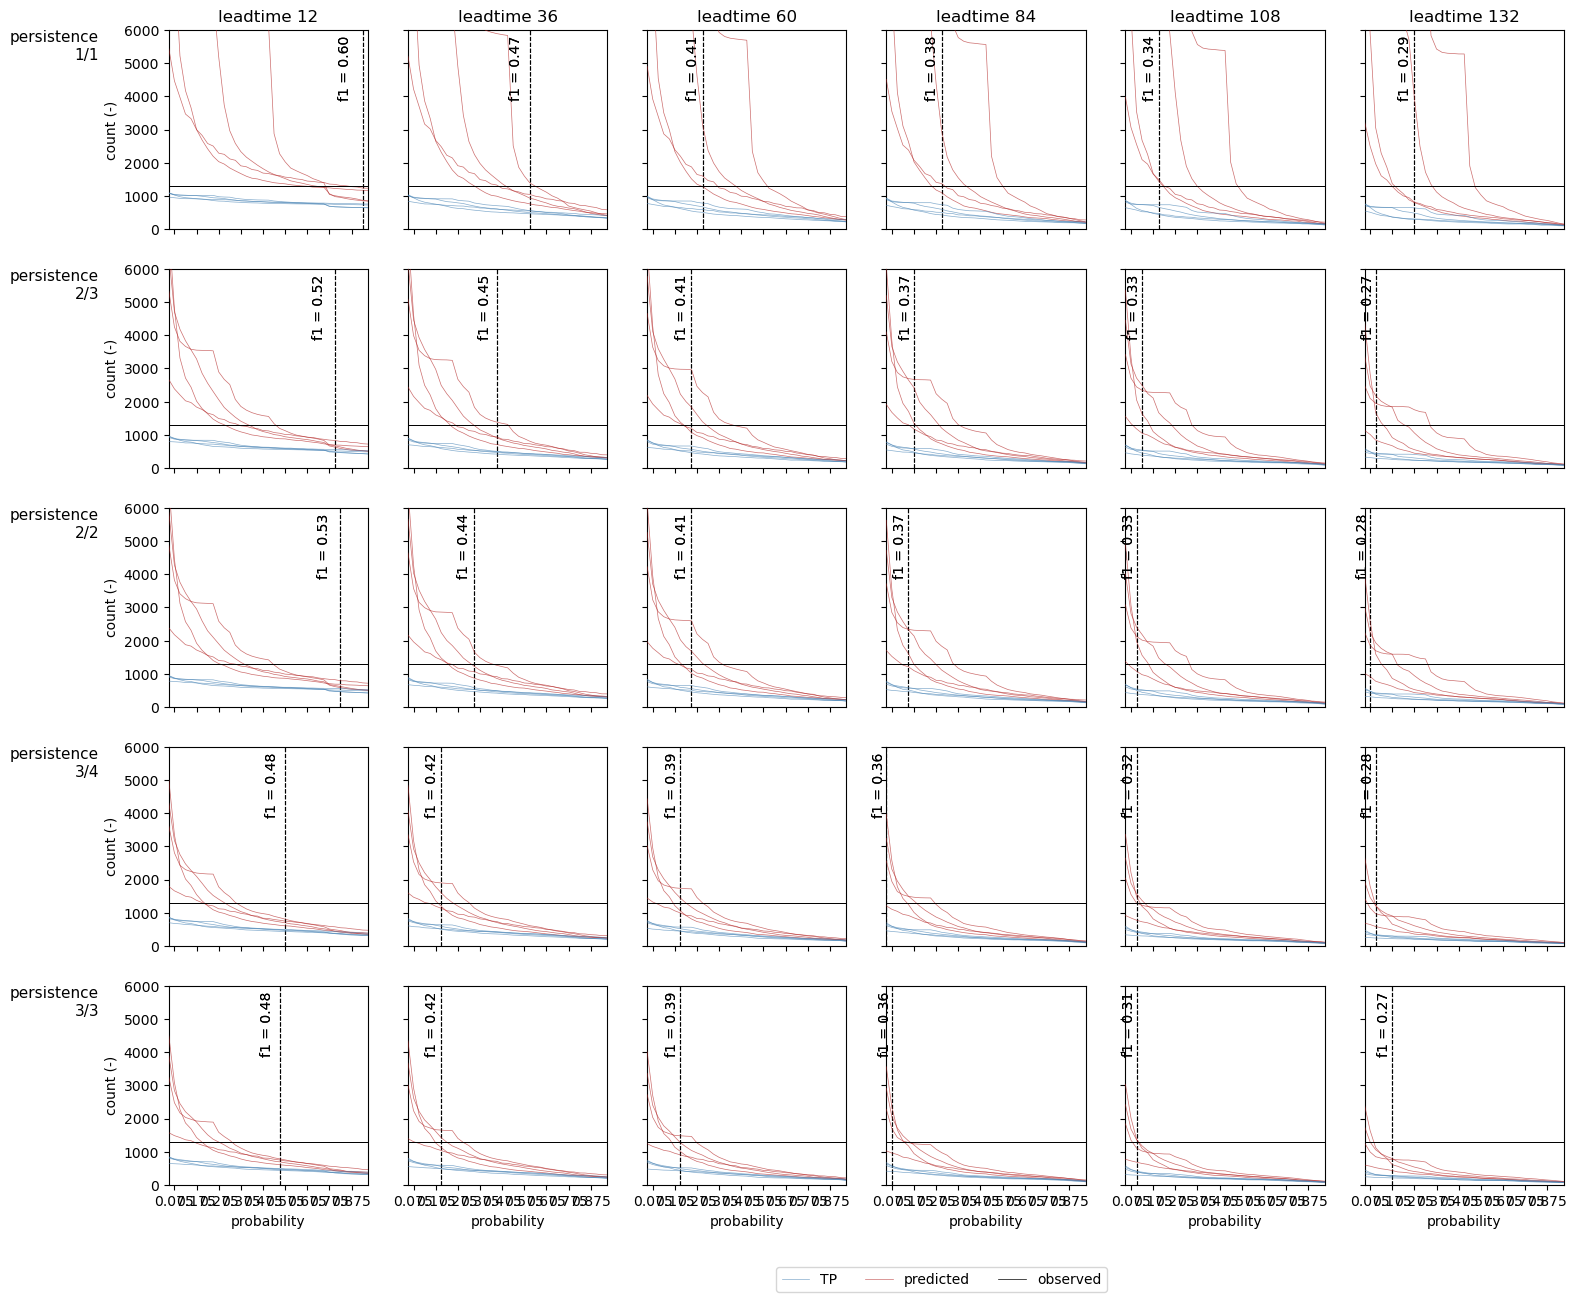

In [10]:
lineplot_hits(hits_lt.sel(persistence=persistences, leadtime=leadtimes),
              coldim='leadtime', rowdim='persistence', ylim=(0, 6000), loc_legend=[0.15, -.04, .5, .1],
              save=f'{path_out}hits_lineplot_persistenceVSleadtimeVSprobability_{stations.shape[0]}points.jpg')

#### 3.1.2 Skill: recall, precision and f1

Best criteria
-------------
leadtime:	12
probability:	0.925
approach:	brier_weighted
persistence:	1/1


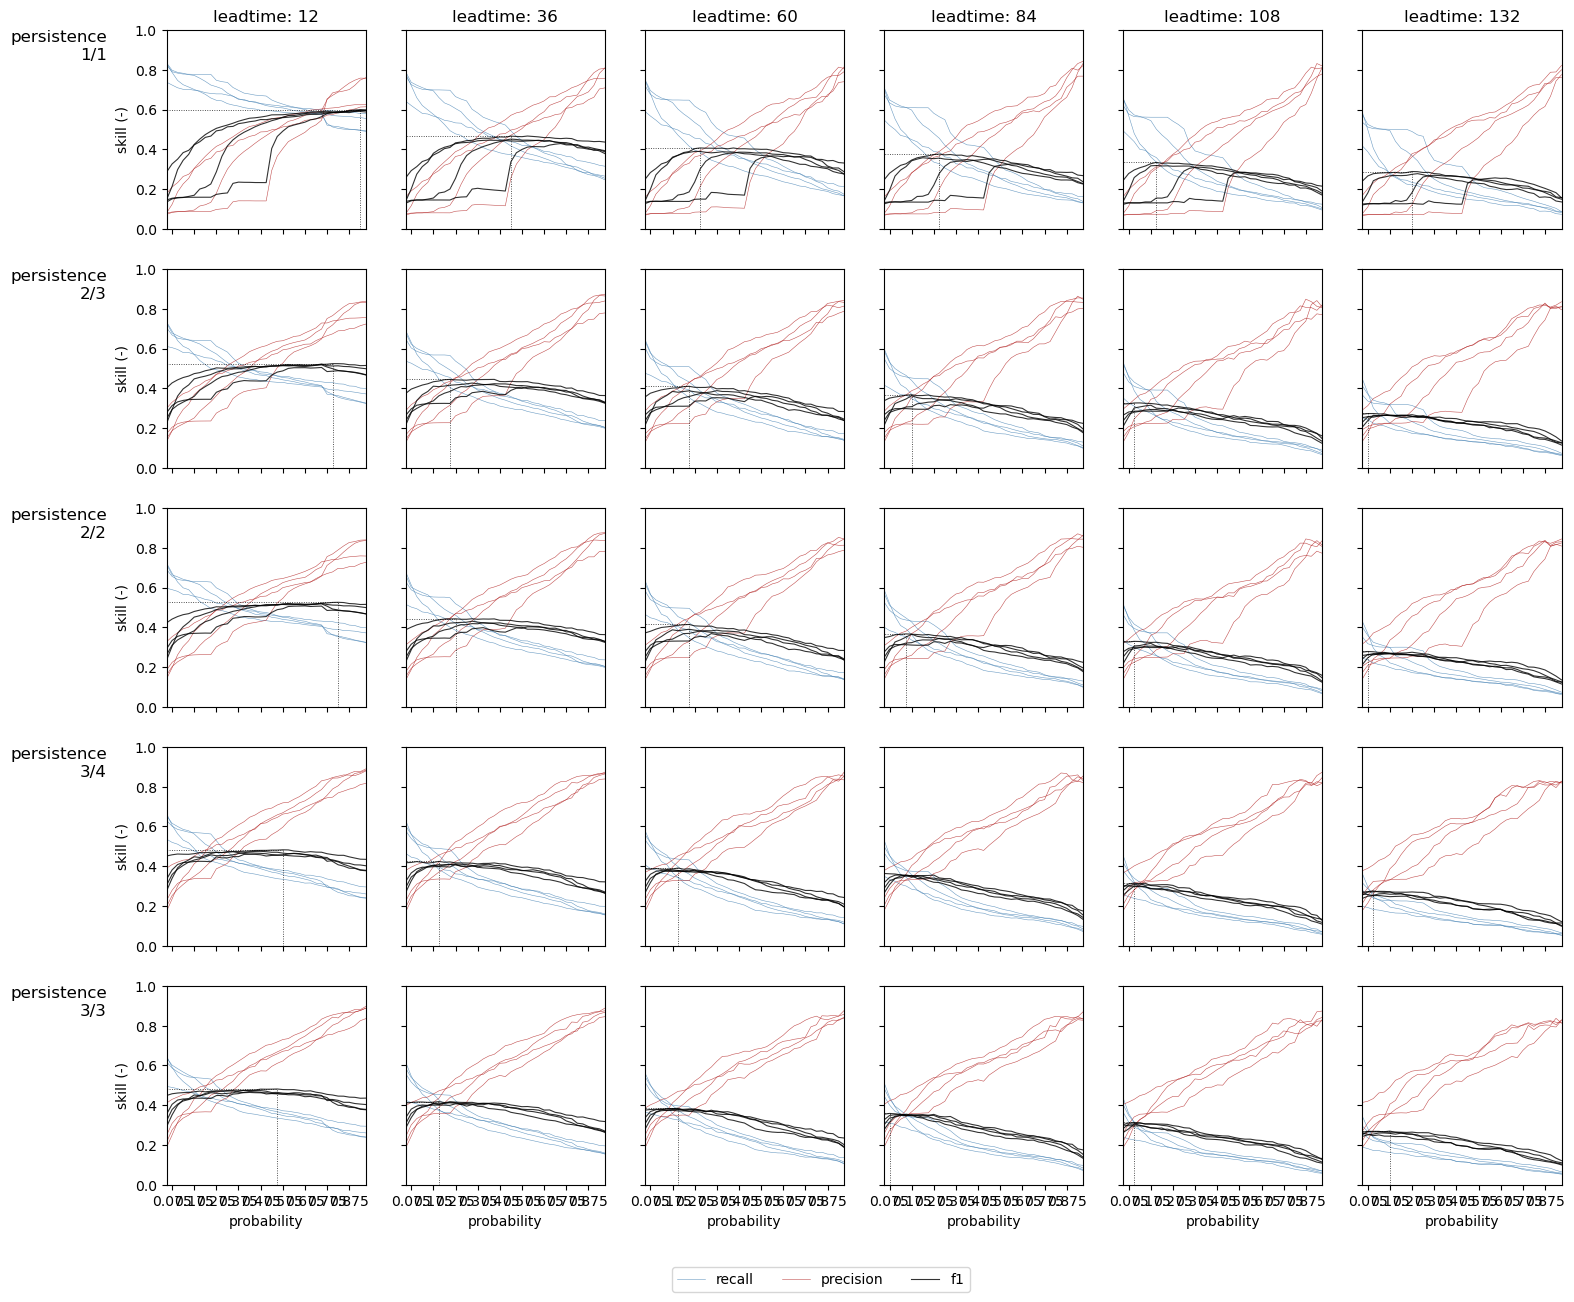

In [11]:
lineplot_skill(skill_lt.sel(persistence=persistences, leadtime=leadtimes), coldim='leadtime',
               save=f'{path_out}skill_lineplot_persistenceVSleadtimeVSprobability_{stations.shape[0]}points.jpg')

print('Best criteria')
print('-------------')
best_criteria = lineplot_skill.best_criteria
for label, value in best_criteria.items():
    print(f'{label}:\t{value}')

Best criteria
-------------
probability:	0.25
approach:	current
persistence:	2/2


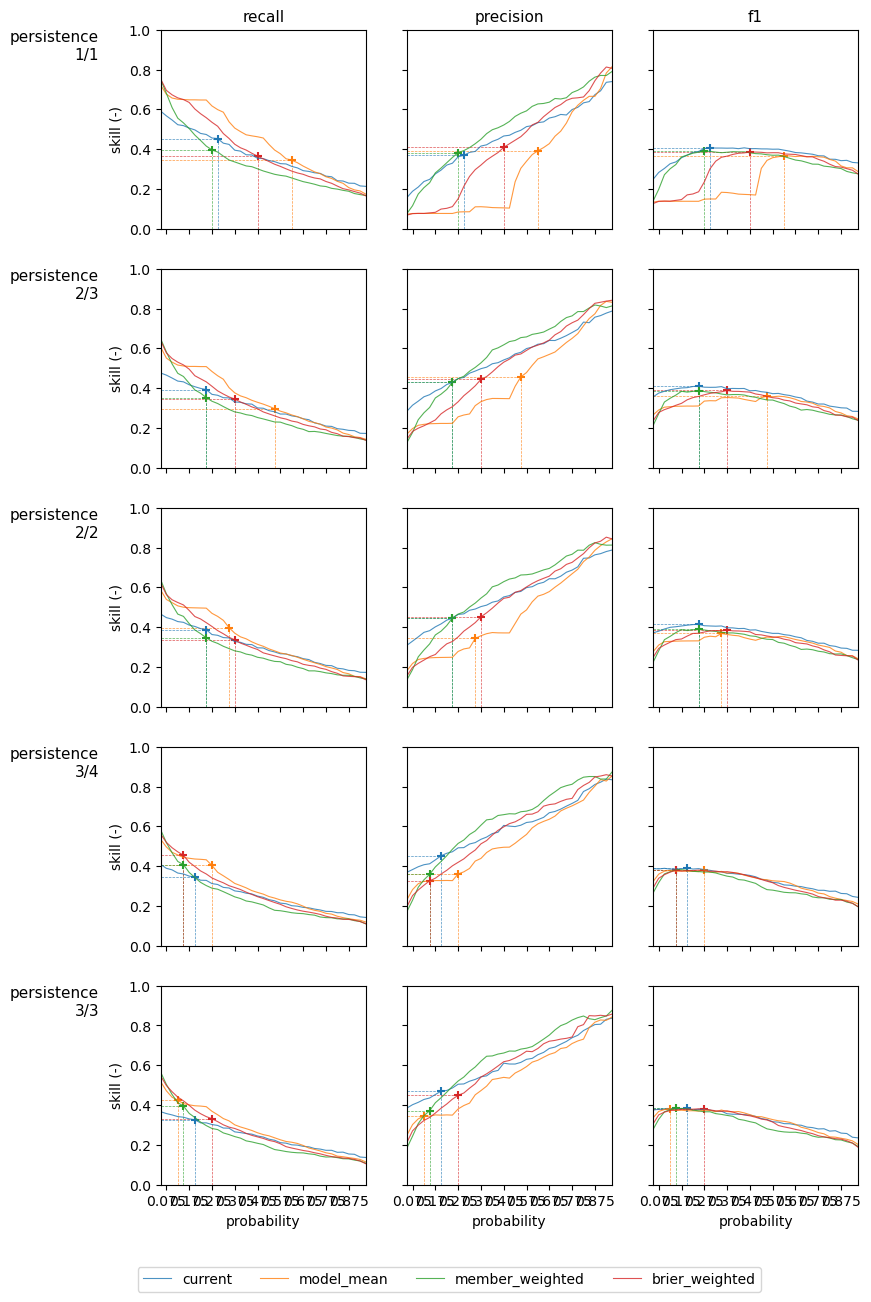

In [12]:
min_leadtime = 60
lineplot_skill(skill_lt.sel(persistence=persistences, leadtime=min_leadtime),
               coldim=None,
               save=f'{path_out}skill_lineplot_persistenceVSprobability_{stations.shape[0]}points_{min_leadtime}h.jpg')

print('Best criteria')
print('-------------')
best_criteria = lineplot_skill.best_criteria
for label, value in best_criteria.items():
    print(f'{label}:\t{value}')

> ***Figure X**. Hits, misses and false alarms depending on leadtime. Each column represents a pobability threshold and each row a persistence criterion. For each graph, the horizontal black line represents the total number of observed events (526). The colourful, solid lines are the hits for each of the approached used to compute total probability. The distance between the horizontal, black line and the colour, solid lines are the misses. The colourful, dashed lines are the total number of predicted events; the distance between these dashed lines and its respective solid line is the number of false alarms.*

### 3.2 Anaylse skill by reporting points

#### 3.2.1 Hits, misses and false alarms

leadtime:	60
probability:	0.25
approach:	current
persistence:	2/2


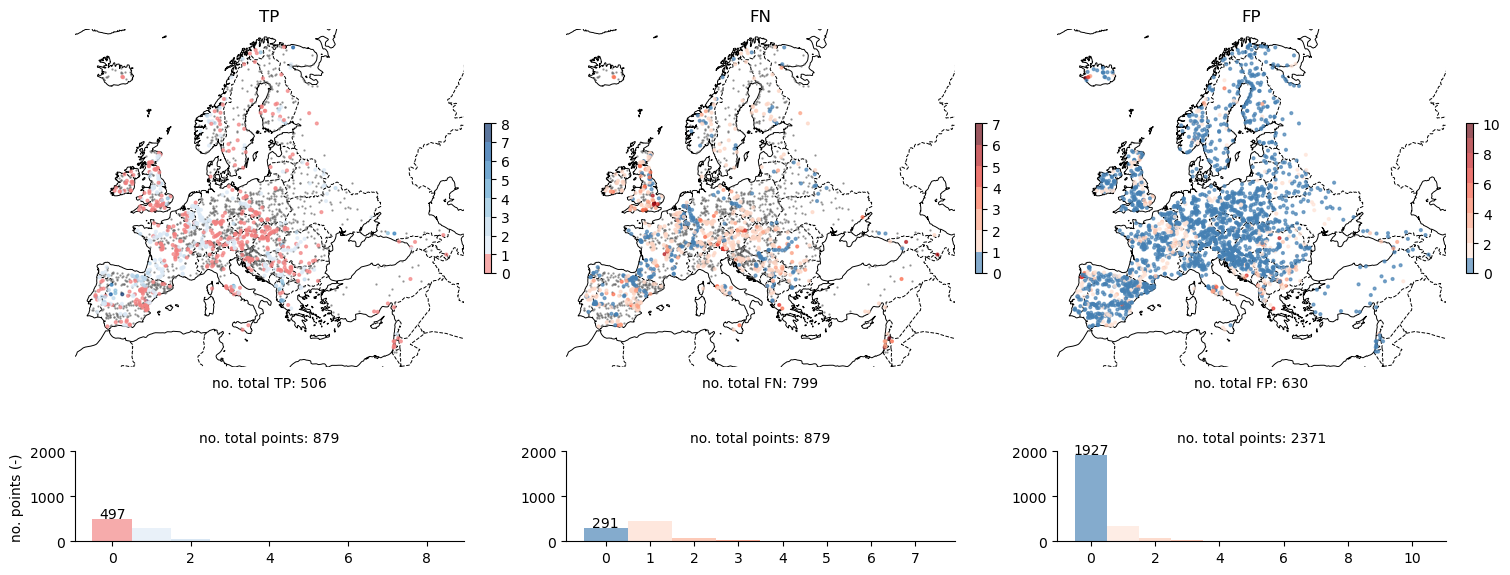

In [13]:
# extract the hits, misses and false alarm for each station based on the best criteria
hits_stn_best = hits_stn.sel(leadtime=min_leadtime).sel(best_criteria)
for var, da in hits_stn_best.items():
    stations[var] = da.to_pandas()

print(f'leadtime:\t{min_leadtime}')
for label, value in best_criteria.items():
    print(f'{label}:\t{value}')
map_hits(stations, cols=['TP', 'FN', 'FP'], mask=mask_stn,
         save=f'{path_out}hits_maps_reporting_points_{stations.shape[0]}points_{min_leadtime}h.jpg')

> ***Figure 8**. Maps of hits, misses and false alarms for each reporting point with the best performing criteria. The colour scale changes depending on the variable with the rational that red (darker red) means worse values, whereas blue (darker blue) better values. In the case of hits (TP) and misses (FN) a mask has been applied to remove reporting points with no observed events (gray points), since none of these variables make sense if there are no observations to predict or miss.*

In [14]:
# station with higher amount of misses
stations.loc[stations.FN > 4].sort_values('FN', ascending=False)

name          X          Y  \
id                                                                              
1572                            Feildes Weir Ultrasonic  3632500.0  3227500.0   
1688                              Lakhish-Ad Halom Park  6647500.0  1347500.0   
1569                 River Lee At Feildes Weir (Gauged)  3632500.0  3232500.0   
2275                                     AGAN NAHARAYIM  6707500.0  1467500.0   
1573                                         Lea Bridge  3627500.0  3212500.0   
1580                                         Tinwell Gs  3612500.0  3332500.0   
2701                                         NAMOKHVANI  6927500.0  2727500.0   
2707                                            EYVAZLI  7337500.0  2562500.0   
2951  La Sioule a Saint-Priest-des-Champs [Fades-Bes...  3767500.0  2567500.0   
3166              La Sioule à Saint-Pourçain-sur-Sioule  3802500.0  2602500.0   

         area       subcatchment    river catchment country  strahler  \
id                                                                      
1572   1175.0                Lee      Lee    Thames      UK       2.0   
1688   1025.0            Lakhish  Lakhish   Lakhish      IL       1.0   
1569   1125.0                Lee      Lee    Thames      UK       2.0   
2275  53050.0  Jordan / Dead Sea   Jordan    Jordan      JO       1.0   
1573   1400.0                Lee      Lee    Thames      UK       2.0   
1580    500.0            Welland  Welland   Welland      UK       1.0   
2701   3550.0              Rioni    RIONI     Rioni      GE       1.0   
2707   2200.0               Aras  VOROTAN      Kura      AZ       4.0   
2951   1350.0             Allier   Sioule     Loire      FR       NaN   
3166   2475.0             Allier   Sioule     Loire      FR       NaN   

      pfafstetter  ...    rl10    rl20    rl50   rl100   rl200   rl500  \
id                 ...                                                   
1572           22  ...    60.1    68.4    79.0    87.0    95.0   105.5   
1688            1  ...    39.7    48.4    59.7    68.1    76.6    87.7   
1569           22  ...    56.4    64.1    74.1    81.6    89.1    98.9   
2275            1  ...  3079.3  3797.9  4728.1  5425.2  6119.8  7036.1   
1573           22  ...    81.2    91.9   105.9   116.3   126.7   140.4   
1580            1  ...    30.0    35.3    42.3    47.5    52.7    59.6   
2701            1  ...   394.9   455.4   533.7   592.3   650.8   728.0   
2707           22  ...   278.3   332.4   402.5   455.0   507.3   576.3   
2951         8211  ...   323.1   377.5   447.9   500.7   553.2   622.6   
3166         8211  ...   335.1   390.8   463.0   517.0   570.9   641.9   

      n_events_obs  TP  FN  FP  
id                              
1572             7   0   7   2  
1688             7   0   7   0  
1569             6   0   6   2  
2275             6   0   6   0  
1573             5   0   5   1  
1580             5   0   5   1  
2701             5   0   5   3  
2707             5   0   5   0  
2951             5   0   5   0  
3166             5   0   5   0  

[10 rows x 23 columns]

In [15]:
# stations with a higher amount of false alarms
stations.loc[stations.FP > 2].sort_values('FP', ascending=False)

name          X          Y     area  \
id                                                                           
2191                                SELFOSS  2847500.0  4872500.0   1425.0   
777                                 Beclean  5387500.0  2777500.0   4375.0   
1469                                Rabaçal  2802500.0  2267500.0   2075.0   
1454                         Ponte Da Barca  2797500.0  2267500.0   2100.0   
2149                               AVLAKION  5307500.0  1857500.0   1550.0   
1746                                 Mostar  4957500.0  2287500.0   3325.0   
3287                               Dynjandi  2882500.0  4882500.0    650.0   
4292                              Contreras  3332500.0  1902500.0   3400.0   
4174               Turano a Rocca Sinibalda  4562500.0  2137500.0    525.0   
4015                                Shkoder  5107500.0  2157500.0   5275.0   
2716                               Dupnitza  5397500.0  2217500.0    725.0   
1083                              Omnesfoss  4262500.0  4057500.0    875.0   
1290                  Río Avia en Ribadavia  2837500.0  2317500.0    625.0   
149                                Sorsele2  4667500.0  4737500.0   6175.0   
3286                         Haukadalsheiði  2912500.0  4897500.0    625.0   
4182                 Tevere a Porta Portese  4527500.0  2087500.0  17300.0   
4119              Tevere a Ponte del Grillo  4537500.0  2112500.0  15275.0   
4113                       Tevere a Ripetta  4527500.0  2092500.0  17250.0   
4172                            Rio Galeria  4517500.0  2082500.0  17700.0   
4324                                 Arenos  3417500.0  1952500.0   1450.0   
4110                   Tevere a Villa Spada  4527500.0  2102500.0  15675.0   
4013                                Shoshaj  5157500.0  2112500.0    775.0   
4142                  Tevere a Foro Italico  4527500.0  2097500.0  17200.0   
4007                                  Paper  5162500.0  2052500.0   1900.0   
3355                      Nilakka, Äyskoski  5162500.0  4532500.0   2350.0   
2701                             NAMOKHVANI  6927500.0  2727500.0   3550.0   
3267                                   Faxi  2897500.0  4887500.0   2825.0   
2995                               Canelles  3542500.0  2142500.0   1650.0   
2755                               Dupnitza  5482500.0  2237500.0   1025.0   
356             Neuhausen, Flurlingerbrücke  4217500.0  2727500.0  11775.0   
2700                         KVEMO NATANEBI  6877500.0  2642500.0    625.0   
2544                          KHADZHIDIMOVO  5472500.0  2152500.0   2325.0   
2083                            FOURGUENONS  4042500.0  2712500.0    925.0   
1748                                  Humac  4932500.0  2262500.0   2600.0   
1289                      Río Avia en Leiro  2837500.0  2322500.0    600.0   
1132                           Håkkadalbrua  4397500.0  4547500.0   2125.0   
815                      Bekes duzzaszto f.  5172500.0  2692500.0   9475.0   
666                                   Doboz  5177500.0  2687500.0   8100.0   
624              N. Ribagorzana A.A.Sta.Ana  3542500.0  2137500.0   1775.0   
589                                Karantsi  5582500.0  2392500.0   6850.0   
4409  Tevere a Ponte del Grillo (discharge)  4512500.0  2077500.0  17775.0   

                                  subcatchment                river  \
id                                                                    
2191                                   Oelfusa              Oelfusa   
777                                       Tisa         Somesul Mare   
1469                                      Lima                 Lima   
1454                                      Lima                 Lima   
2149                                  Akheloos     Acheloos Potamos   
1746                                   Neretva              Neretva   
3287                                    Bruara               Bruara   
4292                                   Cabrie

#### 3.2.2 Skill: recall, precision and f1

leadtime:	60
probability:	0.25
approach:	current
persistence:	2/2


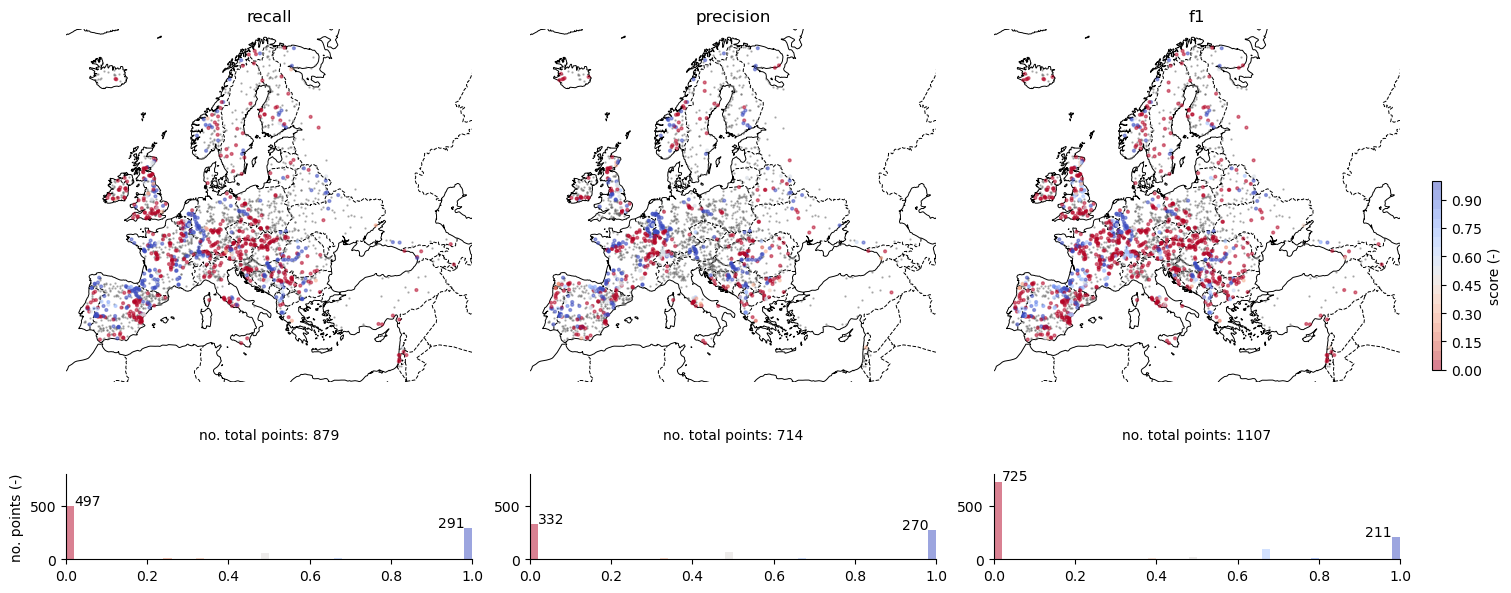

In [16]:
# compute metrics
stations['recall'] = stations.TP / (stations.TP + stations.FN)
stations['precision'] = stations.TP / (stations.TP + stations.FP)
stations['f1'] = 2 * stations.TP / (2 * stations.TP + stations.FN + stations.FP)

# plot maps
print(f'leadtime:\t{min_leadtime}')
for label, value in best_criteria.items():
    print(f'{label}:\t{value}')
cmap_f1, norm_f1 = create_cmap('coolwarm_r', np.arange(0, 1.01, 0.05), name='skill')
map_skill(stations, cols=['recall', 'precision', 'f1'], bins=50, cmap=cmap_f1, norm=norm_f1, alpha=.5,
          save=f'{path_out}skill_maps_reporting_points_{stations.shape[0]}points_{min_leadtime}h.jpg')

### 3.3 Analyse skill by catchment area

In [17]:
# compute hits and skill depending on the minimum catchment area
area_max = np.ceil(stations.area.max() / area_threshold) * area_threshold
skill_area = pd.DataFrame(index=np.arange(area_threshold, area_max, area_threshold), columns=['n_stations', 'TP', 'FN', 'FP', 'recall', 'precision', 'f1'])

for area in skill_area.index:
    mask_area = stations.area >= area
    stations_ = stations[mask_area]
    tp = stations_.TP.sum()
    fn = stations_.FN.sum()
    fp = stations_.FP.sum()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * tp / (2 * tp + fn + fp)
    skill_area.loc[area, :] = mask_area.sum(), tp, fn, fp, recall, precision, f1

# # remove areas over which there weren't observed events
# mask = skill_area['TP'] + skill_area['FN'] == 0
# skill_area = skill_area[~mask]

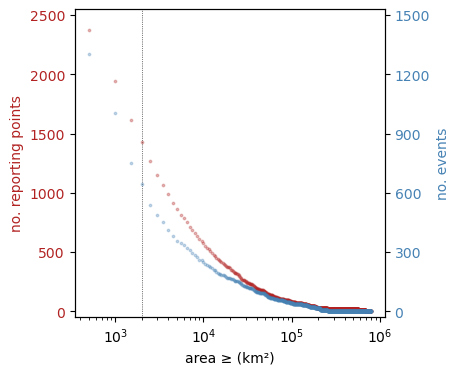

In [18]:
s = 3
alpha = .3
c1 = 'firebrick'
c2 = 'steelblue'

fig, ax1 = plt.subplots(figsize=(4, 4))

ax1.scatter(skill_area.index, skill_area.n_stations, s=s, alpha=alpha, c=c1, zorder=2)
ax1.set_xlabel('area ≥ (km²)')
ax1.set_xscale('log')
ax1.set_ylabel('no. reporting points', c=c1)
ymin1, ymax1 = 0, 2500
yticks = np.linspace(ymin1, ymax1, 6).astype(int)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, c=c1)
ax1.set_ylim(ymin1 - ymax1 * .02, ymax1 * 1.02)

ax1.axvline(x=2000, ls=':', lw=.5, color='k', zorder=0)

ax2 = ax1.twinx()
ax2.scatter(skill_area.index, skill_area.TP + skill_area.FN, s=s, alpha=alpha, c=c2, zorder=1)
ax2.set_ylabel('no. events', c=c2)
ymin2, ymax2 = 0, 1500
yticks = np.linspace(ymin2, ymax2, 6).astype(int)
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticks, c=c2)
ax2.set_ylim(ymin2 - ymax2 * .02, ymax2 * 1.02);

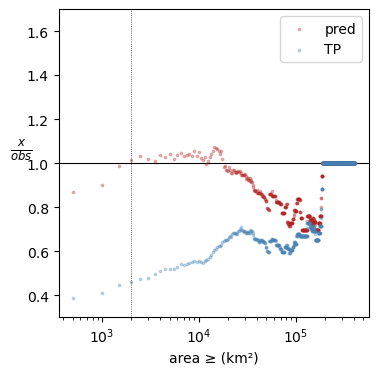

In [19]:
s = 3
alpha = .3
c1 = 'firebrick'
c2 = 'steelblue'

# plot ratio of predicted events and TP vs observed events
obs = obs = skill_area['TP'] + skill_area['FN']
pred = skill_area['TP'] + skill_area['FP']

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(skill_area.index, pred / obs, c=c1, s=s, alpha=alpha, label='pred')
ax.scatter(skill_area.index, skill_area.TP / obs, c=c2, s=s, alpha=alpha, label='TP')
ax.axhline(1, c='k', lw=.8, zorder=0)
ax.axvline(x=2000, ls=':', lw=.5, color='k')
ax.set(xscale='log', xlabel='area ≥ (km²)', ylim=(.3, 1.7))
ax.set_ylabel(r'$\frac{x}{obs}$', rotation=0, fontsize=12)
ax.legend();

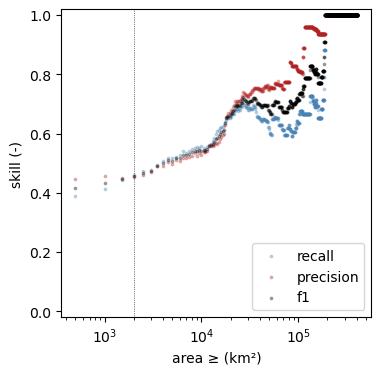

In [20]:
s = 3
alpha = .3

fig, ax = plt.subplots(figsize=(4, 4))

for metric, c in zip(['recall', 'precision', 'f1'], ['steelblue', 'firebrick', 'k']):
    ax.scatter(skill_area.index, skill_area[metric], c=c, s=s, alpha=alpha, zorder=1, label=metric)
ax.axvline(x=2000, ls=':', lw=.5, color='k')
ax.set(xlabel='area ≥ (km²)')
ax.set(ylim=(-.02, 1.02))#xlim=(480, None),
ax.set_xscale('log')
ax.set_ylabel('skill (-)')
ax.legend(loc=4);

In [21]:
area = 10000
mask_area = stations.area >= area
print(f'no. reporting points with a catchment area larger than {area} km²:\t{sum(mask_area)}')

skill_area = hits2skill(hits_stn.sel(id=stations[mask_area].index.to_list(), leadtime=min_leadtime)).sum('id')

best_criteria = skill_area['f1'].argmax(list(skill_area.dims))
best_criteria = {dim: skill_area.isel(best_criteria)[dim].data for dim in best_criteria}

print('\nBest criteria')
print('-------------')
print(f'leadtime:\t{min_leadtime} h')
print(f'area:\t\t{area} km²')
for label, value in best_criteria.items():
    print(f'{label}:\t{value}')

no. reporting points with a catchment area larger than 10000 km²:	575

Best criteria
-------------
leadtime:	60 h
area:		10000 km²
probability:	0.075
approach:	current
persistence:	1/1


***

##### Precision-recall curve

In [188]:
skill_persistence = skill.sel(persistence='2/4')

In [189]:
lab = 'model_mean'

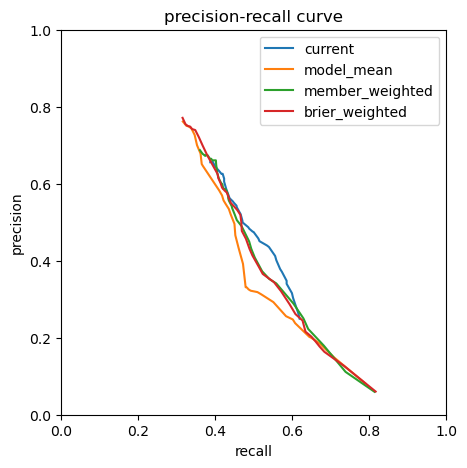

In [190]:
fig, ax = plt.subplots(figsize=(5, 5))

for label in skill.approach.data:
    ax.plot(skill.sel(persistence='2/4', approach=label).recall.data,
            skill.sel(persistence='2/4', approach=label).precision.data,
            label=label)
ax.set(xlim=(0, 1), ylim=(0, 1), xlabel='recall', ylabel='precision', title='precision-recall curve') 
ax.set_aspect('equal')
ax.legend(loc=0);

***

## 4 Rhine & Meuse

In [22]:
import geopandas as gpd

In [23]:
catchment = 'Rhine'
catchments = ['Rhine', 'Meuse / Maas']

In [24]:
# shapefile with rivers
rivers_shp = gpd.read_file(f'../data/GIS/RiversForWebPage_EU_ready.shp')

mask = rivers_shp.BASIN.isin(catchments)
rivers_shp = rivers_shp.loc[mask]

In [25]:
stations_cat = stations.loc[stations.catchment.isin(catchments),:]
print(f'no. reporting points in the {catchment} catchment:\t{stations_cat.shape[0]}')

no. reporting points in the Rhine catchment:	156


In [26]:
mask_obs = stations_cat.n_events_obs > 0

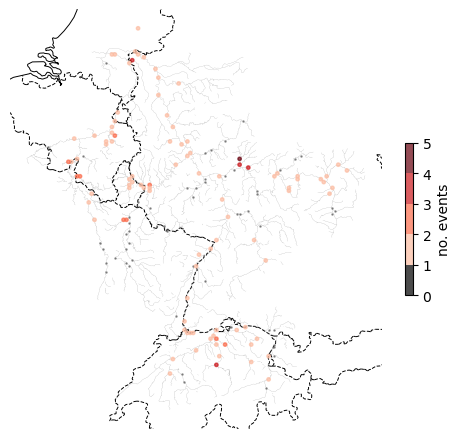

In [27]:
# colormap used for the maps
cmap, norm = create_cmap('Reds', np.arange(0, stations_cat.n_events_obs.max() + 2, 1), 'no. events', [0, (0, 0, 0, 1)])
plot_map_stations(stations_cat.X, stations_cat.Y, stations_cat.n_events_obs, mask=~mask_stn, rivers=rivers_shp,
                  cmap=cmap, norm=norm, size=6, figsize=(6, 6), alpha=.7, lw=.1)
plt.colorbar(plot_map_stations.colorbar, shrink=.33, label='no. events');
# plt.savefig(f'{path_out}/map_observed_events.png', dpi=300, bbox_inches='tight');

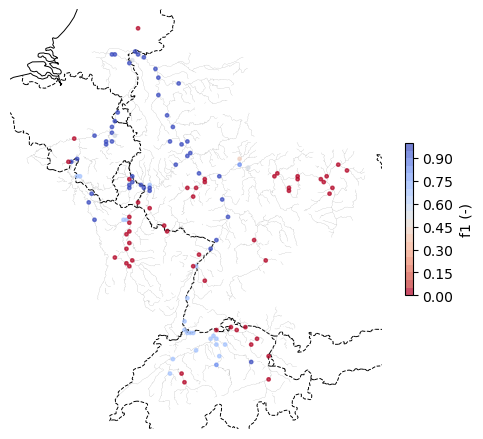

In [28]:
# colormap used for the maps
plot_map_stations(stations_cat.X, stations_cat.Y, stations_cat.f1, rivers=rivers_shp,#, mask=~mask_stn
                  cmap=cmap_f1, norm=norm_f1, size=6, figsize=(6, 6), alpha=.7, lw=.1)
plt.colorbar(plot_map_stations.colorbar, shrink=.33, label='f1 (-)');
# plt.savefig(f'{path_out}/map_observed_events.png', dpi=300, bbox_inches='tight');

In [33]:
stations_cat.sort_values('FN', ascending=False).head(5)

name          X          Y    area subcatchment   river catchment  \
id                                                                              
119   Ilbenstadt  4232500.0  3017500.0  1075.0         Main   Nidda     Rhine   
118        Hanau  4247500.0  3002500.0   900.0         Main  Kinzig     Rhine   
5225    Treignes  3937500.0  3012500.0   600.0        Meuse  Viroin     Rhine   
2022        GOCH  4047500.0  3187500.0  1275.0        Meuse   Niers     Rhine   
362       Halden  4262500.0  2707500.0  1125.0         Thur    Thur     Rhine   

     country  strahler  pfafstetter  ...  rl100  rl200   rl500  n_events_obs  \
id                                   ...                                       
119       DE       NaN         8211  ...   65.7   71.2    78.5             4   
118       DE       NaN         8411  ...  116.0  126.8   141.0             3   
5225      BE       NaN         2741  ...  129.4  141.6   157.5             2   
2022      DE       NaN         2321  ...  111.8  122.1   135.5             3   
362       CH       NaN        14111  ...  861.6  939.8  1043.1             1   

      TP  FN  FP    recall  precision   f1  
id                                          
119    1   3   0  0.250000        1.0  0.4  
118    1   2   0  0.333333        1.0  0.5  
5225   0   2   0  0.000000        NaN  0.0  
2022   1   2   0  0.333333        1.0  0.5  
362    0   1   0  0.000000        NaN  0.0  

[5 rows x 26 columns]

In [34]:
stations_cat.sort_values('FN', ascending=False).head(5)

name          X          Y    area subcatchment   river catchment  \
id                                                                              
119   Ilbenstadt  4232500.0  3017500.0  1075.0         Main   Nidda     Rhine   
118        Hanau  4247500.0  3002500.0   900.0         Main  Kinzig     Rhine   
5225    Treignes  3937500.0  3012500.0   600.0        Meuse  Viroin     Rhine   
2022        GOCH  4047500.0  3187500.0  1275.0        Meuse   Niers     Rhine   
362       Halden  4262500.0  2707500.0  1125.0         Thur    Thur     Rhine   

     country  strahler  pfafstetter  ...  rl100  rl200   rl500  n_events_obs  \
id                                   ...                                       
119       DE       NaN         8211  ...   65.7   71.2    78.5             4   
118       DE       NaN         8411  ...  116.0  126.8   141.0             3   
5225      BE       NaN         2741  ...  129.4  141.6   157.5             2   
2022      DE       NaN         2321  ...  111.8  122.1   135.5             3   
362       CH       NaN        14111  ...  861.6  939.8  1043.1             1   

      TP  FN  FP    recall  precision   f1  
id                                          
119    1   3   0  0.250000        1.0  0.4  
118    1   2   0  0.333333        1.0  0.5  
5225   0   2   0  0.000000        NaN  0.0  
2022   1   2   0  0.333333        1.0  0.5  
362    0   1   0  0.000000        NaN  0.0  

[5 rows x 26 columns]

In [29]:
stations_cat.sort_values('FP', ascending=False).head(5)

name          X          Y     area subcatchment  \
id                                                                             
356  Neuhausen, Flurlingerbrücke  4217500.0  2727500.0  11775.0        Rhine   
357                     Rekingen  4192500.0  2722500.0  14625.0        Rhine   
114                     Odenbach  4152500.0  2952500.0   1075.0         Nahe   
336              Brügg, Aegerten  4117500.0  2672500.0   8300.0         Aare   
335                Bern, Schönau  4132500.0  2647500.0   2975.0         Aare   

     river catchment country  strahler  pfafstetter  ...   rl100   rl200  \
id                                                   ...                   
356  Rhine     Rhine      CH       NaN        15111  ...  1194.4  1279.0   
357  Rhine     Rhine      CH       NaN        13111  ...  1652.6  1765.5   
114   Glan     Rhine      DE       NaN         6211  ...   243.7   268.7   
336   Aare     Rhine      CH       NaN        12511  ...  1435.0  1551.9   
335   Aare     Rhine      CH       NaN        12711  ...   805.0   877.7   

      rl500  n_events_obs  TP  FN  FP  recall  precision        f1  
id                                                                  
356  1390.7             0   0   0   3     NaN        0.0  0.000000  
357  1914.5             1   0   1   2     0.0        0.0  0.000000  
114   301.7             0   0   0   1     NaN        0.0  0.000000  
336  1706.3             1   1   0   1     1.0        0.5  0.666667  
335   973.7             0   0   0   1     NaN        0.0  0.000000  

[5 rows x 26 columns]

In [406]:
stations_cat.sort_values('FP', ascending=False).head(5)

name          X          Y     area subcatchment  \
id                                                                             
356  Neuhausen, Flurlingerbrücke  4217500.0  2727500.0  11775.0        Rhine   
357                     Rekingen  4192500.0  2722500.0  14625.0        Rhine   
337                        Brugg  4182500.0  2707500.0  11550.0         Aare   
359                       Laupen  4112500.0  2647500.0   1925.0         Aare   
358    Rheinfelden (Messstation)  4152500.0  2717500.0  34350.0        Rhine   

     river catchment country  strahler  pfafstetter  ...   rl100   rl200  \
id                                                   ...                   
356  Rhine     Rhine      CH       NaN        15111  ...  1194.0  1279.0   
357  Rhine     Rhine      CH       NaN        13111  ...  1652.0  1765.0   
337   Aare     Rhine      CH       NaN        12511  ...  1761.0  1902.0   
359  Saane     Rhine      CH       NaN        12611  ...   445.0   482.0   
358  Rhine     Rhine      CH       NaN        11711  ...  4546.0  4872.0   

      rl500  n_events_obs  TP  FN  FP  recall  precision        f1  
id                                                                  
356  1390.0             0   0   0   3     NaN   0.000000  0.000000  
357  1914.0             1   0   1   2     0.0   0.000000  0.000000  
337  2089.0             1   1   0   2     1.0   0.333333  0.500000  
359   530.0             1   1   0   2     1.0   0.333333  0.500000  
358  5302.0             1   1   0   1     1.0   0.500000  0.666667  

[5 rows x 26 columns]

In [30]:
(stations_cat.recall == 0).sum() / stations_cat.shape[0]

0.17307692307692307

In [31]:
(stations_cat.precision == 0).sum() / stations_cat.shape[0]

0.1794871794871795

In [32]:
(stations_cat.f1 == 0).sum() / stations_cat.shape[0]

0.3269230769230769

In [33]:
mask_f1 = stations_cat.f1 == 0
mask_recall = stations_cat.recall == 0
mask_precision = stations_cat.precision == 0
stations_cat.loc[mask_f1 & mask_recall & mask_precision]

name          X          Y     area  \
id                                                                              
357                                   Rekingen  4192500.0  2722500.0  14625.0   
931                                    Lauffen  4257500.0  2877500.0   7950.0   
2562                        JONSCHWIL, MUEHLAU  4252500.0  2697500.0    525.0   
2946  La Moder a Schweighouse-sur-Moder [aval]  4162500.0  2852500.0    750.0   

     subcatchment   river catchment country  strahler  pfafstetter  ...  \
id                                                                  ...   
357         Rhine   Rhine     Rhine      CH       NaN        13111  ...   
931        Neckar  Neckar     Rhine      DE       NaN        10311  ...   
2562         Thur    Thur     Rhine      CH       NaN        14111  ...   
2946        Moder   Moder     Rhine      FR       NaN        11211  ...   

       rl100   rl200   rl500  n_events_obs  TP  FN  FP  recall  precision   f1  
id                                                                              
357   1652.6  1765.5  1914.5             1   0   1   2     0.0        0.0  0.0  
931    949.9  1029.7  1134.9             1   0   1   1     0.0        0.0  0.0  
2562   402.9   437.2   482.5             1   0   1   1     0.0        0.0  0.0  
2946   142.7   159.0   180.6             1   0   1   1     0.0        0.0  0.0  

[4 rows x 26 columns]

In [34]:
(stations_cat.f1 == 1).sum() / stations_cat.shape[0]

0.2948717948717949

In [35]:
(stations_cat.f1.isnull()).sum() / stations_cat.shape[0]

0.20512820512820512

In [408]:
stations_cat.sort_values('FN', ascending=False).sort_values('recall', ascending=True).head(5)

name          X          Y    area subcatchment   river  \
id                                                                     
119    Ilbenstadt  4232500.0  3017500.0  1075.0         Main   Nidda   
5225     Treignes  3937500.0  3012500.0   600.0        Meuse  Viroin   
2022         GOCH  4047500.0  3187500.0  1275.0        Meuse   Niers   
118         Hanau  4247500.0  3002500.0   900.0         Main  Kinzig   
5224  Membre Pont  3957500.0  2987500.0  1250.0        Meuse   Smois   

     catchment country  strahler  pfafstetter  ...  rl100  rl200  rl500  \
id                                             ...                        
119      Rhine      DE       NaN         8211  ...   65.0   71.0   78.0   
5225     Rhine      BE       NaN         2741  ...  129.0  141.0  157.0   
2022     Rhine      DE       NaN         2321  ...  111.0  122.0  135.0   
118      Rhine      DE       NaN         8411  ...  116.0  126.0  141.0   
5224     Rhine      BE       NaN         2762  ...  422.0  463.0  517.0   

      n_events_obs  TP  FN  FP    recall  precision        f1  
id                                                             
119              4   1   3   0  0.250000        1.0  0.400000  
5225             2   0   2   0  0.000000        NaN  0.000000  
2022             3   1   2   0  0.333333        1.0  0.500000  
118              3   1   2   0  0.333333        1.0  0.500000  
5224             2   1   1   0  0.500000        1.0  0.666667  

[5 rows x 26 columns]

In [267]:
stations_cat.loc[stations_cat.n_events_obs == 4]

name          X          Y    area subcatchment  river catchment  \
id                                                                            
119  Ilbenstadt  4232500.0  3017500.0  1075.0         Main  Nidda     Rhine   

    country  strahler  pfafstetter  ...  rl100  rl200  rl500  n_events_obs  \
id                                  ...                                      
119      DE       NaN         8211  ...   65.0   71.0   78.0             4   

     TP  FN  FP  recall  precision   f1  
id                                       
119   1   3   0    0.25        1.0  0.4  

[1 rows x 26 columns]

In [269]:
stations_cat.loc[stations_cat.n_events_obs == 3]

name          X          Y    area subcatchment  \
id                                                                         
117                Bad Vilbel  4232500.0  3007500.0  1575.0         Main   
118                     Hanau  4247500.0  3002500.0   900.0         Main   
350   Luzern, Geissmattbrücke  4192500.0  2662500.0  2800.0         Aare   
2022                     GOCH  4047500.0  3187500.0  1275.0        Meuse   

       river catchment country  strahler  pfafstetter  ...  rl100  rl200  \
id                                                     ...                 
117    Nidda     Rhine      DE       NaN         8211  ...  101.0  110.0   
118   Kinzig     Rhine      DE       NaN         8411  ...  116.0  126.0   
350    Reuss     Rhine      CH       NaN        12411  ...  728.0  785.0   
2022   Niers     Rhine      DE       NaN         2321  ...  111.0  122.0   

      rl500  n_events_obs  TP  FN  FP    recall  precision   f1  
id                                                               
117   122.0             3   2   1   0  0.666667        1.0  0.8  
118   141.0             3   1   2   0  0.333333        1.0  0.5  
350   860.0             3   2   1   0  0.666667        1.0  0.8  
2022  135.0             3   1   2   0  0.333333        1.0  0.5  

[4 rows x 26 columns]

In [247]:
stations_cat.n_events_obs.max()

4

In [276]:
hits_stn['TP'].sel(id=119, leadtime=60, probability=.25, persistence='2/2')

<xarray.DataArray 'TP' (approach: 4)>
array([1, 2, 1, 2])
Coordinates:
    leadtime     int32 60
    probability  float64 0.25
  * approach     (approach) object 'current' 'model_mean' ... 'brier_weighted'
    id           int64 119
    persistence  <U3 '2/2'

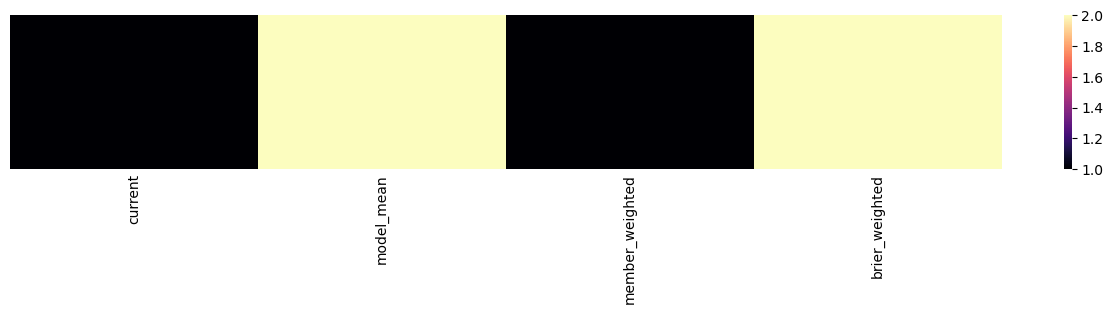

**Duration of the observed events**

In [392]:
Qobs = pd.read_parquet(f'../data/discharge/reanalysis/EFAS_discharge_reanalysis.parquet').loc[datetime(2021, 1, 10):datetime(2022, 12, 31),:]
Qobs.columns = Qobs.columns.astype(int)

obs_exc = (Qobs > stations.rl5).astype(int)

diff = obs_exc.diff(axis=0)

# duration = np.empty((0,))
duration = {}
for stn in tqdm_notebook(obs_exc.columns):
    onsets = diff[stn] == 1
    offsets = diff[stn] == -1
    if onsets.sum() != offsets.sum():
        print(stn, onsets.sum(), offsets.sum(), sep='\t')
        continue        
    if (onsets.sum() > 0) | (offsets.sum() > 0):
        duration_stn = (obs_exc.loc[offsets].index.values - obs_exc.loc[onsets].index.values) / np.timedelta64(1, 'h')
        # duration = np.hstack((duration, duration_stn))
        duration[stn] = duration_stn

In [393]:
duration[4292]

array([36., 12., 18.])

In [394]:
stations.loc[4292, 'rl5']

11.8

In [396]:
max_duration = pd.Series(index=duration.keys())
for stn, duration_stn in duration.items():
    max_duration[stn] = duration_stn.max()
max_duration.sort_values(ascending=False, inplace=True)

(max_duration / 24).head(20)

2685    45.25
2686    32.50
4004    27.00
1107    26.25
316     24.50
2596    24.00
310     18.25
3003    18.00
1075    17.00
2907    16.00
2881    16.00
2376    15.75
1700    15.50
4490    14.50
295     14.50
5163    13.50
5203    13.25
2998    13.25
1702    12.50
1703    12.25
dtype: float64

In [ ]:
s

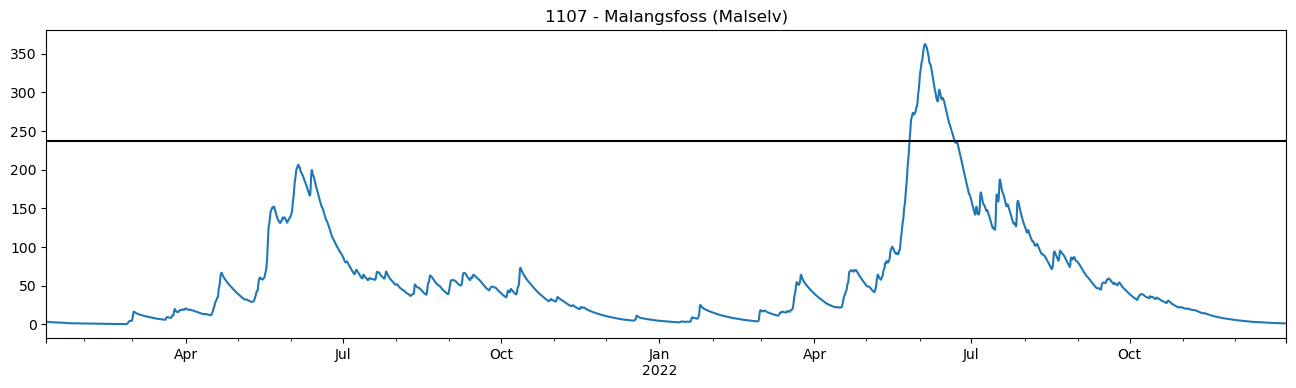

In [401]:
stn = 1107
fig, ax = plt.subplots(figsize=(16, 4))
Qobs[stn].plot(ax=ax)
ax.axhline(stations.loc[stn, 'rl5'], c='k')
ax.set_title('{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'subcatchment']]));

In [373]:
duration_arr = np.empty((0,))
for stn, values in duration.items():
    duration_arr = np.hstack((duration_arr, values))

In [374]:
duration_arr

array([108., 318.,  12., ...,  30.,   6.,   6.])

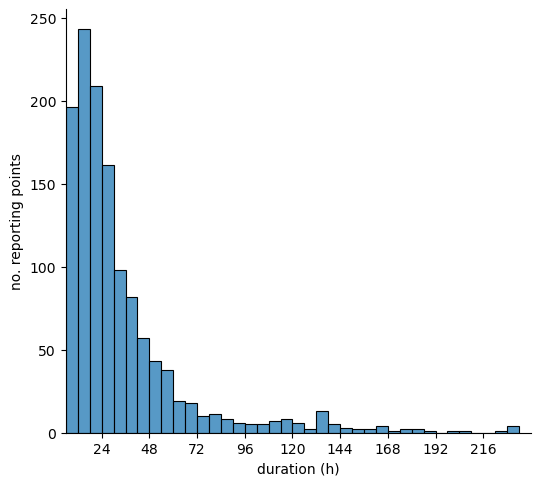

In [402]:
xmin, xmax = 6, 10 * 24
bins = np.arange(xmin, xmax, 6)

fig, ax = plt.subplots(figsize=(6, 5.5))
sns.histplot(duration_arr, ax=ax, bins=bins)
ax.set(xlabel='duration (h)', ylabel='no. reporting points', xlim=(xmin, xmax), xticks=bins[3::4]);
ax.spines[['right', 'top']].set_visible(False)
# ax.legend();
plt.savefig(f'../results/reporting_points/event_duration_distribution_{area_threshold}km2.jpg', dpi=300, bbox_inches='tight')

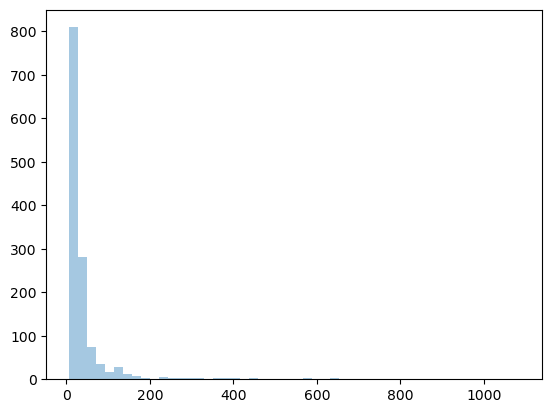

In [345]:
sns.distplot(duration, kde=False);

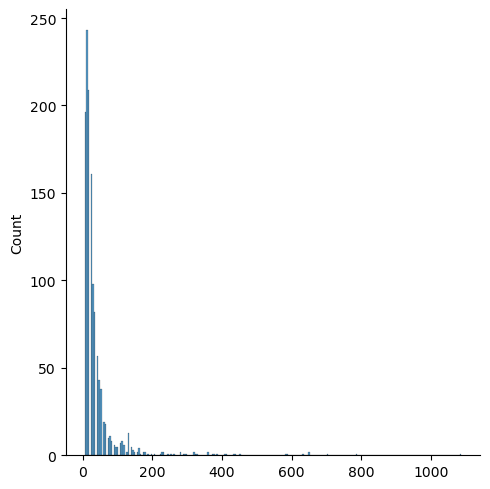

In [343]:
sns.displot(duration);

In [ ]:
durations = 

In [305]:
stn = onsets.sum(axis=0).idxmax()
stn

2686

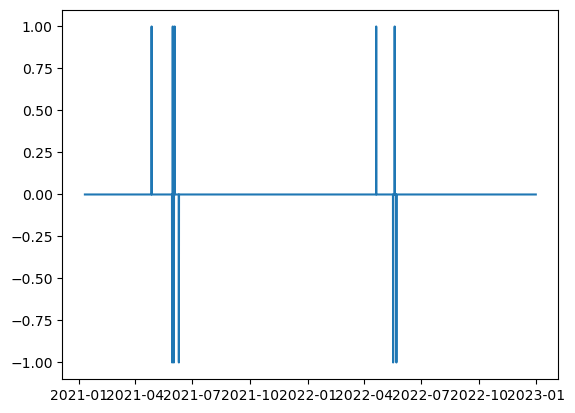

In [306]:
plt.plot(aux[stn])

In [324]:
(aux.loc[offsets[stn]].index.values - aux.loc[onsets[stn]].index.values) / np.timedelta64(1, 'h')

array([786.,  42., 162., 648.,  66.])

In [313]:
onsets[stn].sum()

5

In [314]:
offsets[stn].sum()

5

In [312]:
aux[stn].value_counts()

 0.0    2870
 1.0       5
-1.0       5
Name: 2686, dtype: int64

In [299]:
onsets.sum().sum()

9294

In [300]:
offsets.sum().sum()

0